In [1]:
# Names: Caylum Hurley (22356363), Joe Considine (22344977), Darragh Quinn (22359621)
# Code executes to the end without errors
# Links to third-party implementations used for the submission: https://ale.farama.org/environments/

Names: Caylum Hurley (22356363), Joe Considine (22344977), Darragh Quinn (22359621)
Code executes to the end without errors
Links to third-party implementations used for the submission: https://ale.farama.org/environments/

In [2]:
#Install gynasium with Atari support

%pip install gymnasium[atari,accept-rom-license] ale-py

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
#imports

import sys
print(sys.executable)
print(sys.version)
import numpy as np
import gymnasium as gym
import ale_py
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

from collections import deque

c:\Program Files\Python312\python.exe
3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]


In [4]:
#Registering the Atari environments from the ALE

gym.register_envs(ale_py)

Creating the Pong environment. The rgb_array captures frames for preprocessing and video generation.

In [5]:
#Creates Pong environment
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")

#Reset the enviornment for initial observation
observation, info = env.reset()

#Verifying setup
print("Observation shape: ", observation.shape)
print("Action shape: ", env.action_space)

Observation shape:  (210, 160, 3)
Action shape:  Discrete(6)


Preprocessing Observation. Since the raw images given are RGB images, we need to convert each frame to grayscale, resize to 84*84 pixels, and normalise pixel values to a range [0, 1]. Doing this makes learning efficiency much better as opposed to processing the images directly.

In [6]:
def preprocess_observation(observation):
    gray = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY) #RGB to grayscale
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA) #Resize to DQN input size
    normalised = resized / 255.0 #Normalise pixel values
    
    return normalised

In [7]:
#TODO should min and max be 0 and 1?
#Test preprocessing

processed_observation = preprocess_observation(observation)

print("Processed shape: ", processed_observation.shape)
print("Minimum pixel value: ", processed_observation.min())
print("Maximum pixel value: ", processed_observation.max())

Processed shape:  (84, 84)
Minimum pixel value:  0.25098039215686274
Maximum pixel value:  0.7019607843137254


Our DQN takes the preprocessed game frame as the input and outputs a Q-value for each possible action. The action with the highest Q-value is chosen as the agent's policy action during exploitation. Our architecture uses three convolutional layers for spatial feature extraction, two fully connected layers for decision making, and a final linear output that produces our Q-value.

Convolutional layers detect the ball and the paddles in their relative positions.

ReLU used to introduce non-linearity so that the model can learn more complex scenarios.

Fully connected layers combine the extracted features for a Q-value estimate.

Output layer has one neuron per action, producing the award for each action.

In [8]:
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        
        #Convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels=1, # Input is a single, preprocessed grayscale image of shape (1, 84, 84)
            out_channels=32,
            kernel_size=8,
            stride=4
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=4,
            stride=2
        )
        
        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            stride=1
        )
        
        self.fc1 = nn.Linear(7*7*64, 512) #Feature map size (7*7*64)
        
        self.fc2 = nn.Linear(512, n_actions) #One Q-value per action
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.view(x.size(0), -1) #Flatten tensor for fully connected layers
        
        x = F.relu(self.fc1(x))
        q_values = self.fc2(x)
        
        return q_values

Creating Target and Online Networks

In [9]:
device = torch.device("cpu")
print(device)

#Number of actions
n_actions = env.action_space.n

#Creates Q-network
policy_net = DQN(n_actions).to(device)

#Creates target Q-network
target_net = DQN(n_actions).to(device)

#Copy weights from policy to target network
target_net.load_state_dict(policy_net.state_dict())

#Setting target mode to evaluation mode
target_net.eval()

cpu


DQN(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)

In [10]:
#Converting a preprocessed frame into a tensor
state_tensor = torch.tensor(processed_observation, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

#Pass state through online network
with torch.no_grad():
    q_values = policy_net(state_tensor)
    
#Print Q-Values
print("Q-values: ", q_values)
print("Q-values shape: ", q_values.shape)

Q-values:  tensor([[-0.0466, -0.0361,  0.0142, -0.0009,  0.0364,  0.0119]])
Q-values shape:  torch.Size([1, 6])


We are using a Replay Buffer to store transitions explored by the agent in the environment. Replay is very important for stabilising DQN training. The agent samples random mini-batches from the replay buffer. Doing it this way improves data efficiency by reusing experiences and it breaks temporal correlations between consecutive frames. 

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done)) #Appends a tuple

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

We are giving the replay buffer a large capacity to ensure a diverse set of experiences are available for training. When buffer is filled, older experiences are discarded automatically. This reduces overfitting and makes training more stable.

At the start of training, the replay buffer does not contain enough transitions to form a mini-batch. Training updates are therefore skipped until the buffer has a sufficient number of experiences.

In [12]:
replay_buffer = ReplayBuffer(capacity=1000)

for i in range(5):
    replay_buffer.push(
        processed_observation,
        env.action_space.sample(),
        1.0,
        processed_observation,
        False
    )
    
    print("Replay buffer size: ", len(replay_buffer))
    
    batch_size = 2 # must be <= buffer size
    
    if len(replay_buffer) >= batch_size:
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    
        print("Sampled batch size: ", len(states))
        print("Sampled actions: ", actions)
    else: 
        print("Not enough samples in replay buffer to sample a batch yet")

Replay buffer size:  1
Not enough samples in replay buffer to sample a batch yet
Replay buffer size:  2
Sampled batch size:  2
Sampled actions:  (np.int64(0), np.int64(1))
Replay buffer size:  3
Sampled batch size:  2
Sampled actions:  (np.int64(0), np.int64(1))
Replay buffer size:  4
Sampled batch size:  2
Sampled actions:  (np.int64(0), np.int64(1))
Replay buffer size:  5
Sampled batch size:  2
Sampled actions:  (np.int64(2), np.int64(1))


In [13]:
episodes = 100
batch_size = 32
gamma = 0.99
learning_rate = 1e-4
target_update = 1000
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995

optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
steps_completed = 0

In [14]:
#def choose_action(state, epsilon):
    #if random.random() < epsilon:
        #return env.action_space.sample()
    #else:
        #with torch.no_grad():
            #return policy_net(state).argmax().item()

In [15]:
def choose_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            return policy_net(state_tensor).argmax(dim=1).item()

Don't know if Caylum is going to write part of the markdown for below cell but I am writing a bit about the maximisation bias

We reduceded maximation bias with Double DQN in the below cell. The policy network picks the next best action while the target network evaluates the value of the chosen action. The result is a more accurate target estimate and greater training stability. This leads to much more consitent performance in our Pong environment.

In [16]:
import torch

def training_step():
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
    
    # Convert numpy arrays to PyTorch tensors
    states = [torch.tensor(state, dtype=torch.float32).unsqueeze(0) if state.ndim == 2 else torch.tensor(state, dtype=torch.float32) for state in states]
    next_states = [torch.tensor(state, dtype=torch.float32).unsqueeze(0) if state.ndim == 2 else torch.tensor(state, dtype=torch.float32) for state in next_states]

    
    # Concatenate tensors
    states = torch.stack(states).to(device)
    next_states = torch.stack(next_states).to(device)
    
    actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
    dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(1).to(device)
    
    dones = dones.float()
    
    # Continue with the rest of the training logic...

    q_vals = policy_net(states).gather(1, actions)
    
    #Double DQN to fix maximization bias
    with torch.no_grad():
        next_actions = policy_net(next_states).argmax(dim=1, keepdim=True) # Get actions from policy network
        next_q_vals = target_net(next_states).gather(1, next_actions) # Action evaluation from target network
        target_q_vals = rewards + (gamma * next_q_vals * (1 - dones))

    loss = F.mse_loss(q_vals, target_q_vals)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [17]:
episode_rewards = []

for episode in range(episodes):
    observation, info = env.reset()
    state = preprocess_observation(observation)
    state = np.expand_dims(state, axis=0)  #3 dimensions

    total_reward = 0.0
    done = False
    
    while not done:
        steps_completed += 1

        action = choose_action(state, epsilon)
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_state = preprocess_observation(next_observation)
        next_state = np.expand_dims(next_state, axis=0) 

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            training_step()

        if steps_completed % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(total_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")



Episode 0, Total Reward: -19.0, Epsilon: 0.995
Episode 10, Total Reward: -21.0, Epsilon: 0.946
Episode 20, Total Reward: -20.0, Epsilon: 0.900
Episode 30, Total Reward: -21.0, Epsilon: 0.856
Episode 40, Total Reward: -19.0, Epsilon: 0.814
Episode 50, Total Reward: -21.0, Epsilon: 0.774
Episode 60, Total Reward: -21.0, Epsilon: 0.737
Episode 70, Total Reward: -21.0, Epsilon: 0.701
Episode 80, Total Reward: -20.0, Epsilon: 0.666
Episode 90, Total Reward: -20.0, Epsilon: 0.634


Results before DDQN
![alt text](image.png)

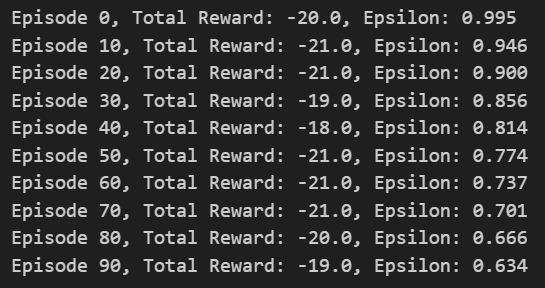

After DDQN
![alt text](image-1.png)

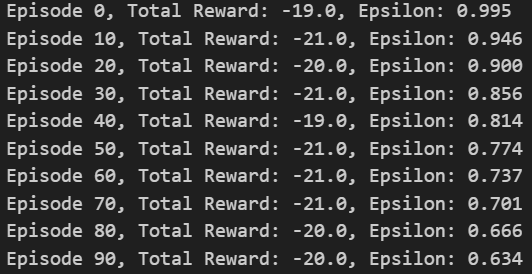

Would probably want to see difference with more data.

Might need to find a way to train the model faster or more efficiently apart from using DDQN. Ideas might be adding frame stacking or upping number of episodes. Maybe different loss function like Huber loss.

In [18]:
#Markdown cell for Learning update (Will update soon)

References:

Double DQN - https://www.emergentmind.com/topics/double-q-learning-algorithm

